# Amazonia-1 on AWS Open Data

## Accessing Cloud Optimized Multi-Band Raster Data


With the AWS ASDI STAC API we can search and load various geospatial datasets. Below we'll work with the Amazonia-1 Satelite WFI Camera, Level-4 Orthorectified data, sourced from Cloud Optimized GeoTIFFs (COGs) [hosted on AWS](https://registry.opendata.aws/amazonia/). In this example, we read in 4 band imagery within a bounding box.

First we install any necessary packages. Please note that the following block of code only needs to be run if needed within a new workspace and that you may need to restart the kernel to use updated packages. The code block only needs to be run once for each AWS Sagemaker Studio profile.

In [1]:
%pip install --upgrade pip -q
%pip install matplotlib 'pystac_client>=0.5.0' stackstac rasterio folium -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# All imports in the order they are used in the code
import os
from pystac_client import Client
import stackstac

import shapely as shp
import folium

import rasterio

We'll use `pystac_client` to submit our search query, stackstac to load and composite our rasters as an Xarray DataArray, and rio-tiler to performantally load individual COGs.

### Querying the AWS STAC API with Pystac Client

First, we define the URL to our STAC API, a service that allows us to submit search queries for spatio-temporal assets (like elevation raster tiles).

Next, we open this URL with `pystac_client`, which allows us to use the client's search method. `client.search` accepts many different arguments to specify the search query. Common query parameters are `time_range` and `bbox` (the spatial bounding box). Since the DEM was collected at one point in time, we will only specify the "where" with a `bbox` describing the minx, miny, maxx, maxy coordinates in lat/lon degrees.

In [3]:
import os
from pystac_client import Client
import stackstac

# making a connection to AWS STAC API
API_ROOT_URL = "https://dev.asdi-catalog.org"
client = Client.open(API_ROOT_URL)

# Search near Curitiba Brazil
bbox = [-49.320232, -25.626009, -48.927635, -25.323504]
source_search = client.search(
        collections=["AMAZONIA1-WFI"], 
        bbox=bbox,
        max_items=100
    )
# getting the metadata and links to data assets in STAC format
source_items = source_search.item_collection()
print("Number of WFI tiles: ", len(source_items))

Number of WFI tiles:  15


### Loading an OpenStreetMap(OSM) descriptive map of the same area

To better understand our area of interest, we can create a descriptive map with our bounding box. We'll load an OpenStreetMap basemap that includes place names, annotations for water and forested areas, and roads. We'll use `folium` to access and plot this map. To learn more about `folium`, check out the [documentation](https://python-visualization.github.io/folium/). We'll use our bounding box to specify where we want to center our map and pick a zoom level that shows us detail around San Ignacio.

In [4]:
# import shapely for manipulation and analysis of geometric objects
# in this case to find the center of the bounding box bbox
import shapely as shp
bbox_poly = shp.geometry.box(*bbox)
center_point = (bbox_poly.centroid)

In [5]:
import folium
m = folium.Map(location=[center_point.y, center_point.x], zoom_start=6)
bbox_style_blue = {'fillColor': '#3388ff', 'color': '#3388ff', 'fillOpacity':'0.05'} #make bbox red
folium.GeoJson(source_items.to_dict(), name="items", style_function=lambda x:bbox_style_blue).add_to(m)
bbox_style_red = {'fillColor': '#ff0000', 'color': '#ff0000'} #make bbox red
folium.GeoJson(bbox_poly, name="bbox", style_function=lambda x:bbox_style_red).add_to(m)
m

### Explore the Items

The query resulted in 15 scenes that match the query. Lets look more closely at the properties in the STAC records.

To Start you can print a single Item, and Jupyter will give you an interactive tree to explore.

In [6]:
source_items[3]

id: AMAZONIA_1_WFI_20230720_035_019_L4
"bbox: [-55.425427, -27.918553, -45.273965, -19.652529]"
gsd: 64.0
datetime: 2023-07-20T13:46:39Z
platform: amazonia-1
proj:epsg: 32722
instruments: ['WFI']
amazonia:row: 19
amazonia:path: 35
view:off_nadir: 0.000144213
sat:orbit_state: descending


In [7]:
# After exploring several items, you'll notice 2 different projections are used.
# For stacking later, we'll need to pick one to reproject all reads to the same projection.
# TODO: maybe count the number of tiles per projection?
for item in source_items:
    print(item.properties.get('proj:epsg'))

32723
32722
32723
32722
32723
32723
32722
32722
32723
32722
32723
32722
32723
32722
32723


### Loading DEM raster into an Xarray DataArray

There are multiple options for loading STAC items into in-memory arrays. `stackstac` allows you to specify a list of items from a `pystac_client` search and load those items as a single xarray DataArray. Similar to it's name, `stackstac` handles loading and then stacking individual COGs that fall within our `pystac` query.

We have 4 bands and multiple time samples over the same area.


In [8]:
# rio cogeo info was used to determine the resolution of the data
# feedback when using STAC projection extension include transform
# Load an Xarray DataArray with a stack of scenes and bands
# Specify the projection since 2 are present in the source
# Specify the bbox to limit the data read
resolution = source_items[0].properties.get("gsd")

stack = stackstac.stack(
    source_items, 
    resolution=resolution, #can get this from gsd
    epsg=32723, # data is in two projections, 2 utm zones we need to pick one to return data
    bounds_latlon=bbox)

/home/studio-lab-user/.conda/envs/dem/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Looking at the structure of the data cube
- 15 scenes, 
- each scene is 4 bands, 
- with a resolution of 635x545

In [9]:
stack

<xarray.DataArray 'stackstac-4c9257abd0be7e97bfa7111a08a0354b' (time: 15,
                                                                band: 4,
                                                                y: 545, x: 635)>
dask.array<fetch_raster_window, shape=(15, 4, 545, 635), dtype=float64, chunksize=(1, 1, 545, 635), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * time                                   (time) datetime64[ns] 2023-06-18T1...
    id                                     (time) <U34 'AMAZONIA_1_WFI_202306...
  * band                                   (band) <U2 'B1' 'B2' 'B3' 'B4'
  * x                                      (x) float64 6.49e+04 ... 1.055e+05
  * y                                      (y) float64 7.193e+06 ... 7.159e+06
    amazonia:path                          (time) int64 34 35 34 35 ... 34 35 34
    ...                                     ...
    sat:platform_international_designator  <U9 '2021-015A'
    sat:orbit_state                        <U10 'descending'
    common_name                            (band) <U5 'blue' 'green' 'red' 'nir'
    center_wavelength                      object None
    full_width_half_max                    object None
    epsg                                   int64 32723
Attributes:
    spec:        RasterSpec(epsg=32723, bounds=(64896.0, 7158592.0, 105536.0,...
    crs:         epsg:32723
    transform:   | 64.00, 0.00, 64896.00|\n| 0.00,-64.00, 7193472.00|\n| 0.00...
    resolution:  64.0

Since all the data is from the same bounding box, this is also a timeseries of 15 different times for the same location

In [15]:
# Lets print the Time dimension coordinates
stack["time"].values

array(['2023-06-18T13:26:17.000000000', '2023-06-20T13:46:20.000000000',
       '2023-06-23T13:26:24.000000000', '2023-06-25T13:46:26.000000000',
       '2023-06-28T13:26:29.000000000', '2023-06-30T13:46:30.000000000',
       '2023-07-03T13:26:32.000000000', '2023-07-05T13:46:34.000000000',
       '2023-07-10T13:46:37.000000000', '2023-07-13T13:26:38.000000000',
       '2023-07-18T13:26:39.000000000', '2023-07-20T13:46:39.000000000',
       '2023-07-23T13:26:39.000000000', '2023-07-25T13:46:39.000000000',
       '2023-07-28T13:26:38.000000000'], dtype='datetime64[ns]')

## Explore Scenes

Let plot a single band for each time, reading only the data we need right when it's needed. 

> If this had a been a bigger selection of data falling back on thumbnail Assets would be more efficient.

Turns out clouds are a big issue, so need to find a time without clouds. With the following code block you will see only 5 of the 15 times are good data.

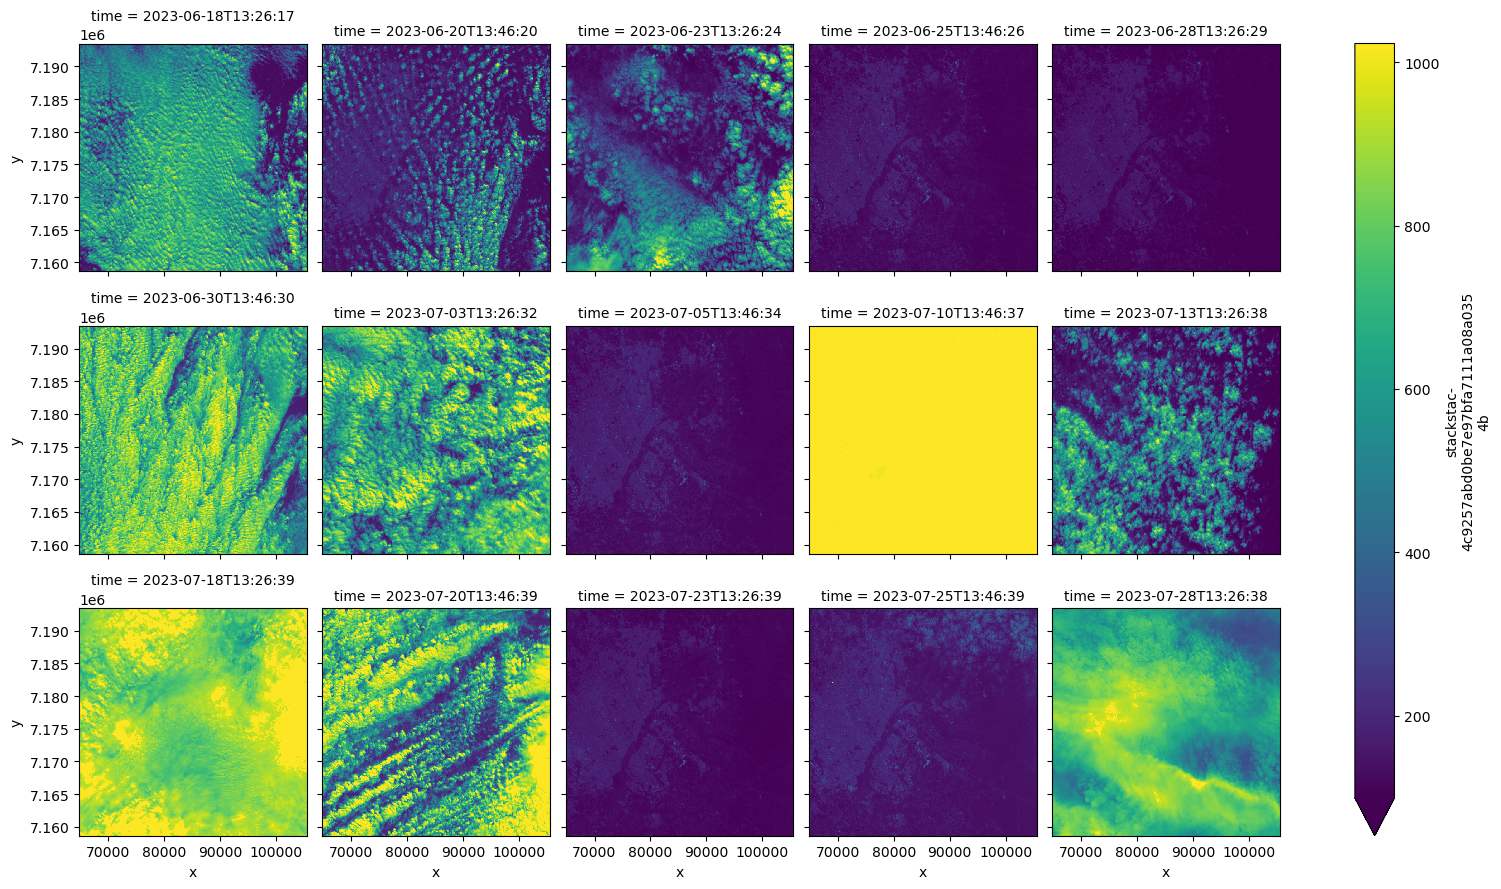

In [11]:
with rasterio.Env(AWS_NO_SIGN_REQUEST=True):
    stack.isel(band=0).plot(col="time", robust=True, col_wrap=5)

#### Plotting 3 Bands

Now that we've found good data, we can plot a 3 band image, matching the Bands to RGB for display.

For the Amazonia WFI sensor if you look at the Asset properties on the STAC item you can see the bands labelled.


In [12]:
print(stack.band.values)
print(stack.common_name.values)

['B1' 'B2' 'B3' 'B4']
['blue' 'green' 'red' 'nir']


Now for the first example in true color Red, Green, Blue.


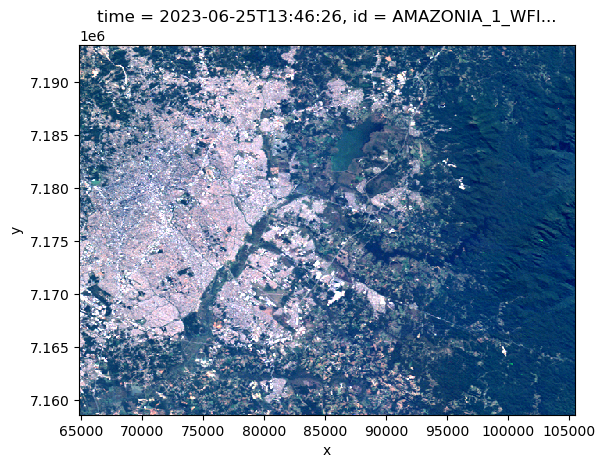

In [13]:
# Try a 3 band plot
with rasterio.Env(AWS_NO_SIGN_REQUEST=True):
    stack.sel(time="2023-06-25T13:46:26.000000000", band=['B3','B2','B1']).plot.imshow(robust=True)

Then for the second in false color infrared, Near Infrared, Red, Green.

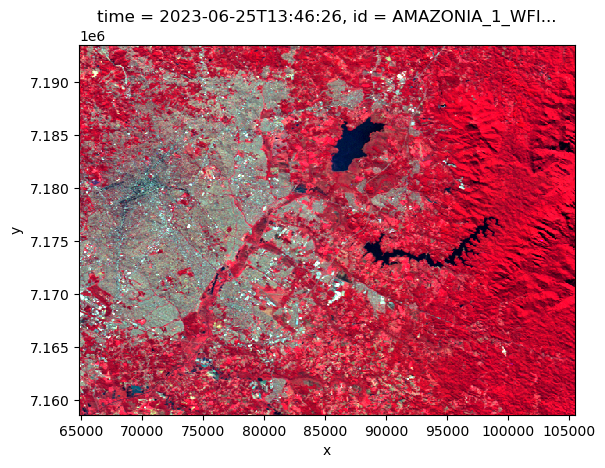

In [14]:
# False color infrared plot
with rasterio.Env(AWS_NO_SIGN_REQUEST=True):
    stack.sel(time="2023-06-25T13:46:26.000000000", band=['B4','B3','B2']).plot.imshow(robust=True)